# **Прогноз стоимости медицинской страховки**
# Цель задачи
Основная задача - на основе набора данных разработать модель МО, которая будет прогнозировать годовые медицинские расходы (`annual_medical_cost`). Необходимо построить модель, которая принимает на вход персональные данные и информацию о здоровье человека и предсказывает, сколько денег будет потрачено на его медицинское обслуживание в течение года.

В качестве входных данных для модели будут использоваться такие характеристики, как возраст (`age`), пол (`sex`), индекс массы тела (`bmi`), статус курения (`smoker`), регион проживания (`region`), доход (`income`), наличие хронических заболеваний (`chronic_count`) и другие параметры.
Прогнозируемой величиной является годовые медицинские расходы (`annual_medical_cost`).

Так как целевая переменная - непрерывная числовая величина, то это задача регрессии.

# **Импорты**

In [1]:
import kagglehub as kh
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, completeness_score

# **Настройка окружения**

In [2]:
warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")

# **Загрузка данных**

In [3]:
path = kh.\
dataset_download("mohankrishnathalla/medical-insurance-cost-prediction")
df = pd.read_csv(f"{path}/medical_insurance.csv")

100%|██████████| 5.62M/5.62M [00:00<00:00, 5.93MB/s]

Extracting files...


# **EDA: Характеристики и Визуализация**

Форма данных: (100000, 54)


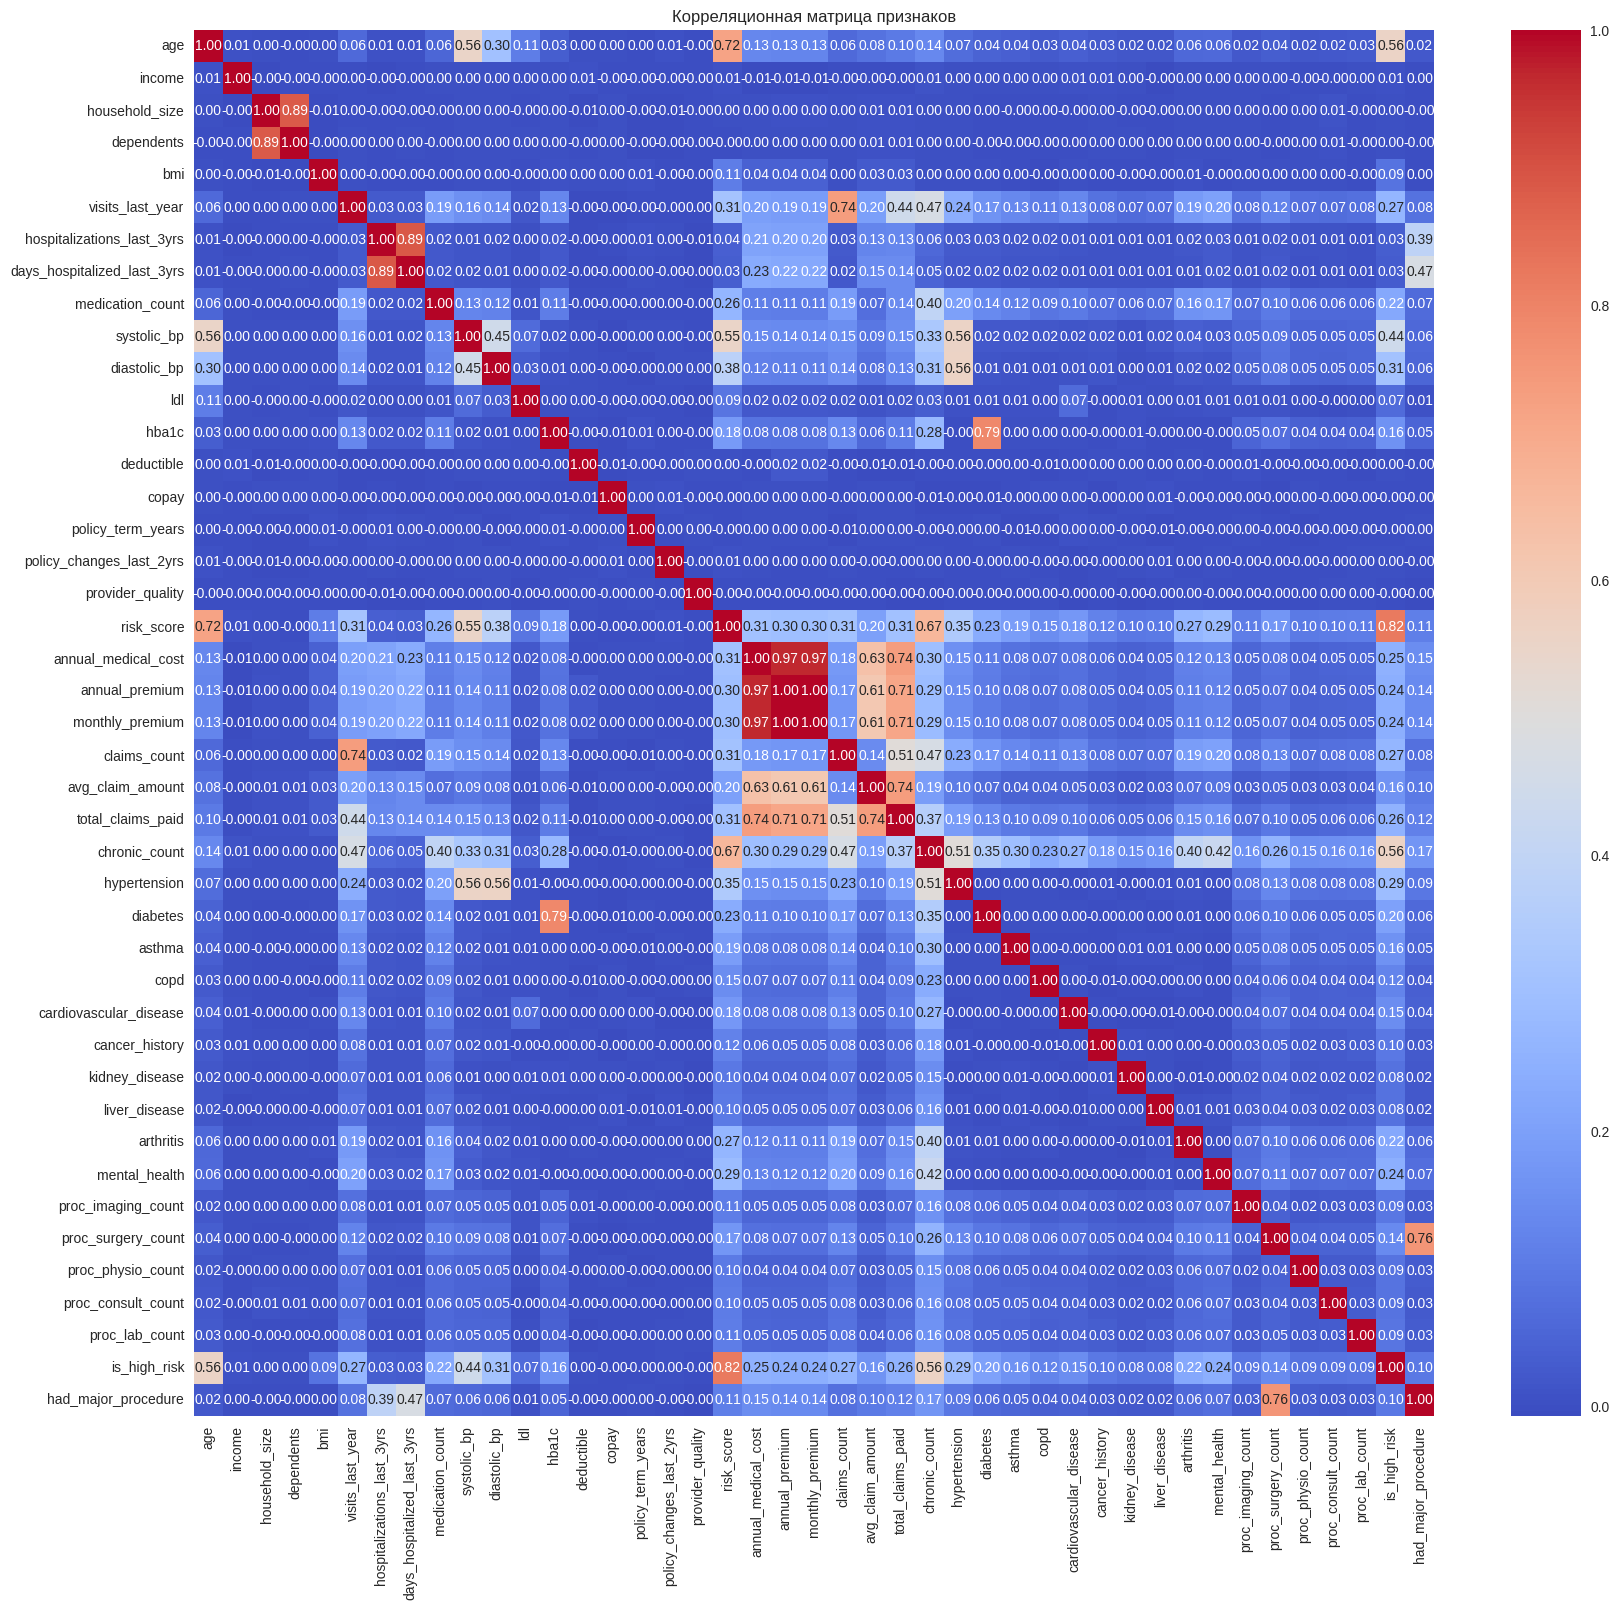

In [4]:
print(f"Форма данных: {df.shape}")
df.drop("person_id", axis = 1, errors = "ignore", inplace = True)

plt.figure(figsize = (20, 18))
sns.heatmap(df.select_dtypes(include = [np.number]).corr(), annot = True,
            fmt=  ".2f", cmap = "coolwarm")
plt.title("Корреляционная матрица признаков")
plt.show()

# **Обработка пропущенных значений**

In [5]:
df["alcohol_freq"] = df["alcohol_freq"].fillna("Never")

# **Обработка категориальных признаков**

In [6]:
categorical_cols = df.select_dtypes(include = ["object"]).columns
df_encoded = pd.get_dummies(df, columns = categorical_cols, drop_first = True)

# **Исключение коррелированных переменных**

In [7]:
X_tmp = df_encoded.drop("annual_medical_cost", axis = 1)
corr_matrix = X_tmp.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                  k = 1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_final = df_encoded.drop(columns = to_drop)
print(f"Удалены избыточные признаки: {to_drop}")

Удалены избыточные признаки: ['monthly_premium']


# **Борьба с несбалансированностью**

In [8]:
y = np.log1p(df_final["annual_medical_cost"])
X = df_final.drop("annual_medical_cost", axis = 1)

# **Нормализация**

In [9]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

# **Разбивка на выборки**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size = 0.2,
                                                    random_state = 42)


# **Классификатор (регрессия) ближайших соседей**

In [11]:
knn = KNeighborsRegressor()

# **Подбор оптимального гиперпараметра (k)**

In [12]:
params_knn = {"n_neighbors": range(3, 15)}
knn_search = RandomizedSearchCV(knn, params_knn, n_iter = 5, cv = 3,
                                scoring = "neg_mean_absolute_error",
                                random_state = 42)
knn_search.fit(X_train, y_train)
best_knn = knn_search.best_estimator_
print(f"Лучшее k для KNN: {knn_search.best_params_}")

Лучшее k для KNN: {'n_neighbors': 13}


# **Ошибки на выборках для KNN**

In [13]:
y_pred_knn = best_knn.predict(X_test)
mae_knn = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_knn))
print(f"MAE KNN: {mae_knn:.2f}")

MAE KNN: 1370.26


# **Другие классификаторы**

In [14]:
models = {
  "RandomForest": RandomForestRegressor(n_estimators = 100, max_depth = 10,
                                        random_state = 42, n_jobs = -1),
  "LightGBM": LGBMRegressor(random_state = 42, verbose = -1)
}

print("Сравнение моделей (Кросс-валидация MAE):")
for name, model in models.items():
  scores = cross_val_score(model, X_train, y_train, cv = 3,
                           scoring = "neg_mean_absolute_error")
  print(f"{name}: {-scores.mean():.4f}")

Сравнение моделей (Кросс-валидация MAE):
RandomForest: 0.0154
LightGBM: 0.0109


In [15]:
lgb_model = LGBMRegressor(random_state = 42, verbose = -1)
lgb_model.fit(X_train, y_train)
y_pred_final = lgb_model.predict(X_test)

final_mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_final))
final_r2 = r2_score(np.expm1(y_test), np.expm1(y_pred_final))

print(f"MAE: {final_mae:.2f}")
print(f"R2: {final_r2:.4f}")

MAE: 51.30
R2: 0.9738


# **Промежуточные выводы**
1. Финальная модель (LightGBM) достигла MAE: 51.30 и R2: 0.9738;
2. Логарифмирование целевой переменной помогло справиться с дисбалансом расходов;
3. KNN показал себя хуже бустинга на данных высокой размерности.


# **Подготовка истинных меток**

In [16]:
y_true_labels = pd.qcut(y, q = 3, labels = [0, 1, 2]).astype(int)
print("Истинные категории расходов (0, 1, 2) созданы для 100 000 строк.")

Истинные категории расходов (0, 1, 2) созданы для 100 000 строк.


# **Понижение размерности (PCA)**

In [17]:
pca = PCA(n_components = 2, random_state = 42)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA завершен. Сжатие данные до 2-х колонок.")
print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.2f}")

PCA завершен. Сжатие данные до 2-х колонок.
Объясненная дисперсия: 0.11


# **Кластеризация (3 метода)**

In [18]:
print("Запуск KMeans...")
kmeans = KMeans(n_clusters = 3, random_state = 42, n_init = "auto")
kmeans_labels = kmeans.fit_predict(X_scaled)

print("Запуск DBSCAN (на PCA данных)...")
dbscan = DBSCAN(eps = 0.3, min_samples = 100)
dbscan_labels = dbscan.fit_predict(X_pca)

print("Запуск Gaussian Mixture...")
gmm = GaussianMixture(n_components = 3, random_state = 42)
gmm_labels = gmm.fit_predict(X_scaled)

Запуск KMeans...
Запуск DBSCAN (на PCA данных)...
Запуск Gaussian Mixture...


# **Визуализация и Сравнение**

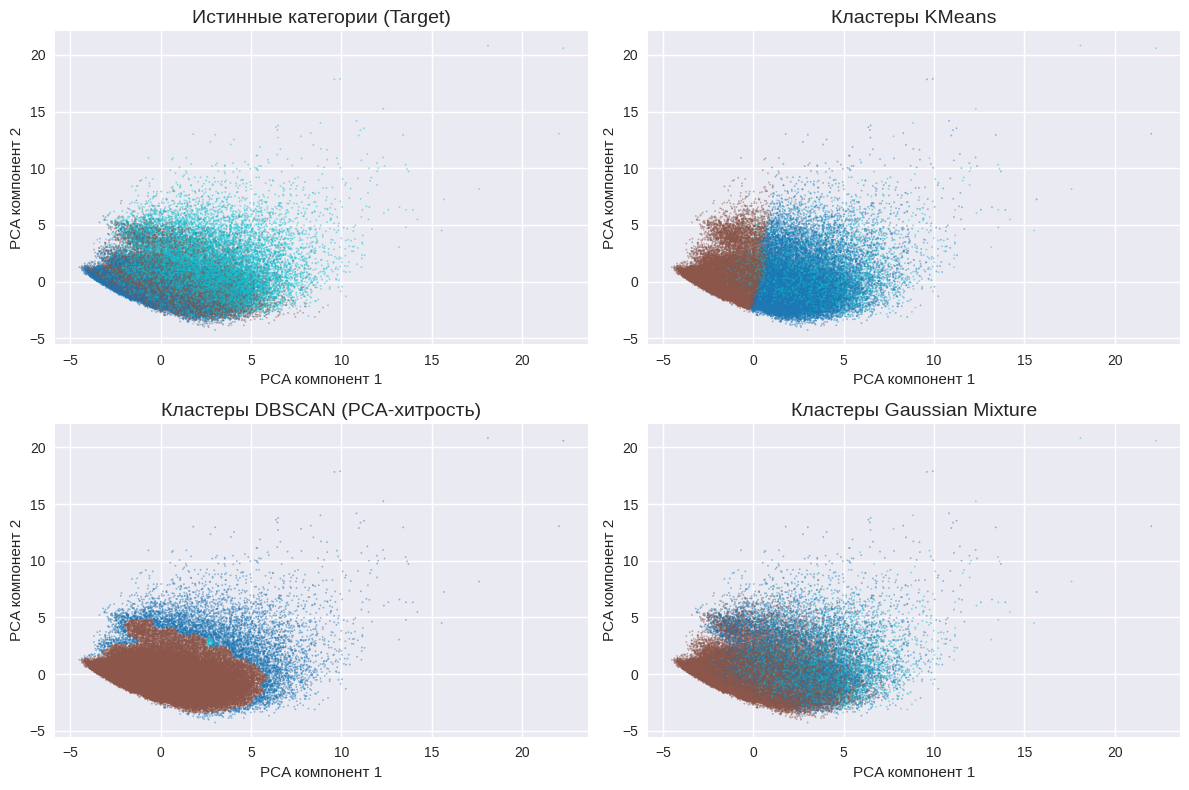


--- ОЦЕНКА СОВПАДЕНИЯ С РЕАЛЬНОСТЬЮ ---
KMeans: Индекс ARI = 0.0711 (мера сходства с реальными расходами)
DBSCAN: Индекс ARI = 0.0001 (мера сходства с реальными расходами)
Gaussian Mixture: Индекс ARI = 0.0175 (мера сходства с реальными расходами)


In [19]:
fig, axes = plt.subplots(2, 2, figsize = (12, 8))

plots = [
  (y_true_labels, "Истинные категории (Target)"),
  (kmeans_labels, "Кластеры KMeans"),
  (dbscan_labels, "Кластеры DBSCAN (PCA-хитрость)"),
  (gmm_labels, "Кластеры Gaussian Mixture")
]

for i, (labels, title) in enumerate(plots):
  ax = axes[i // 2, i % 2]
  scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c = labels,
                      cmap = "tab10", s = 1, alpha = 0.4)
  ax.set_title(title, fontsize = 14)
  ax.set_xlabel("PCA компонент 1")
  ax.set_ylabel("PCA компонент 2")

plt.tight_layout()
plt.show()

def check_quality(name, labels, true_labels):
  mask = (labels != -1)
  if not any(mask):
    print(f"{name}: Не удалось выделить кластеры (все точки - шум)")
    return
  ari = adjusted_rand_score(true_labels[mask], labels[mask])
  print(f"{name}: Индекс ARI = {ari:.4f} (мера сходства с реальными расходами)")

print("\n--- ОЦЕНКА СОВПАДЕНИЯ С РЕАЛЬНОСТЬЮ ---")
check_quality("KMeans", kmeans_labels, y_true_labels)
check_quality("DBSCAN", dbscan_labels, y_true_labels)
check_quality("Gaussian Mixture", gmm_labels, y_true_labels)

# **Выводы**
1. Оценка качества визуализации (PCA): метод главных компонент (PCA) позволил сжать данные до двумерия. Суммарная дисперсия составила 11%, что означает, что данные имеют очень сложную структуру, и визуализация на плоскости теряет 89% полезной информации.

2. Анализ структуры данных: на графиках видно, что 100000 наблюдений образуют единое плотное облако без четко выраженных сгустков или разрывов. KMeans и GMM просто разрезали облако на сегменты, не найдя естественных границ.

3. Сравнение с истинными метками (Target): показатели индекса ARI оказались близки к нулю (от 0.0001 до 0.07), что означаеи, что структура персональных данных не формирует группы, которые напрямую соответствовали бы уровням расходов. Здоровье и стоимость страховки - это непрерывные величины, и попытка разбить их на корзины методом обучения без учителя (без знания цены) не увенчалась успехом.

4. Сравнение методов:
    - KMeans показал лучший среди всех (хотя и низкий) ARI = 0.07. Он разделил данные на наиболее устойчивые геометрические сегменты.
    - Gaussian Mixture (GMM) отработал схожим образом, но из-за высокой плотности данных не смог выделить вероятностные кластеры точнее, чем KMeans.
    - DBSCAN показал худший результат (ARI около 0). При заданных параметрах он выделил одно огромное ядро и шум, что подтверждает отсутствие пустых пространств в плотности данных.

Для данного датасета задача регрессии намного эффективнее, чем кластеризация. Люди с разным уровнем здоровья и расходов сильно перемешаны, и типичных портретов пациентов, четко разделенных по цене, не существует.